# IPC Threshold Setting using Percentiles

This notebook looks at setting percentiles using IPC data for each country.

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch, Rectangle
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D


In [109]:
def read_csv_robust(path, encodings=("utf-8-sig","cp1252","latin-1","utf-16","utf-16le","utf-16be"), **kwargs):
    """
    Read a CSV with multiple encoding fallbacks.
    Returns: (DataFrame, used_encoding)
    """
    # sensible defaults
    kwargs.setdefault("sep", None)          # auto-detect delimiter
    kwargs.setdefault("engine", "python")   # needed for sep=None

    last_err = None
    for enc in encodings:
        try:
            df = pd.read_csv(path, encoding=enc, **kwargs)
            return df, enc
        except UnicodeDecodeError as e:
            last_err = e
            continue

    # last resort: keep going and mark bad bytes
    df = pd.read_csv(path, encoding="cp1252", encoding_errors="replace", **kwargs)
    return df, "cp1252+replace"

In [ ]:

ipc_df = pd.read_csv("download (5).csv")
cerf_file_path = "Data_ CERF Donor Contributions and Allocations - allocations (3).csv"
cerf_df, _ = read_csv_robust(cerf_file_path)
#cerf_df = pd.read_csv("C:/Users/pauni/Downloads/Data_ CERF Donor Contributions and Allocations - allocations (3).csv")
fa_df, _ = read_csv_robust("Flash Appeals Clean.csv")
surge_df, _ = read_csv_robust("surge_data.csv")
#validation_df = pd.read_excel("G:/Shared drives/Data Science/CERF Anticipatory Action/ROSEA/ROSEA Threshold Methodology/Validation Data - CERF, Flash Appeals, Support Package.xlsx", sheet_name="Slow Onset")

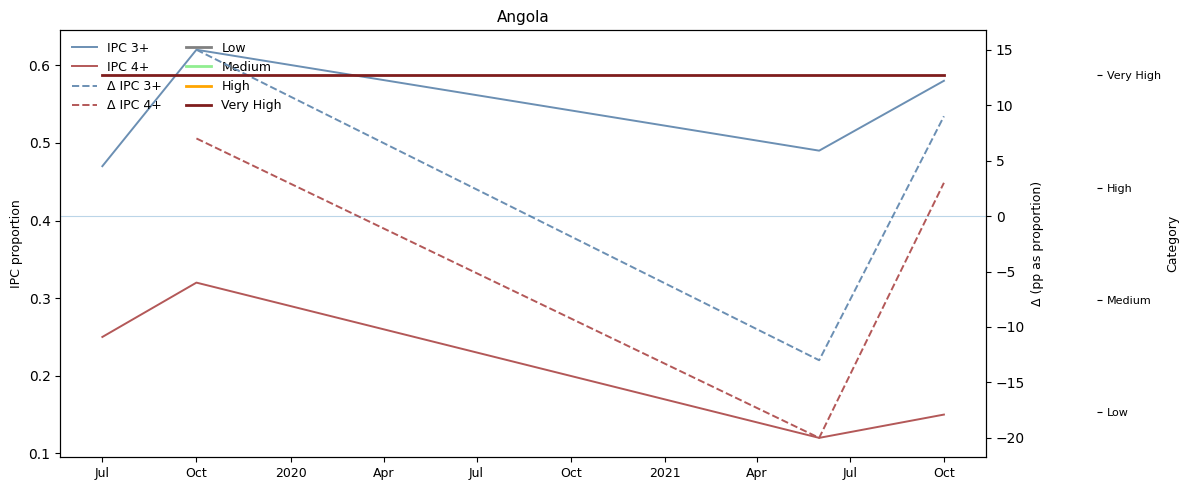

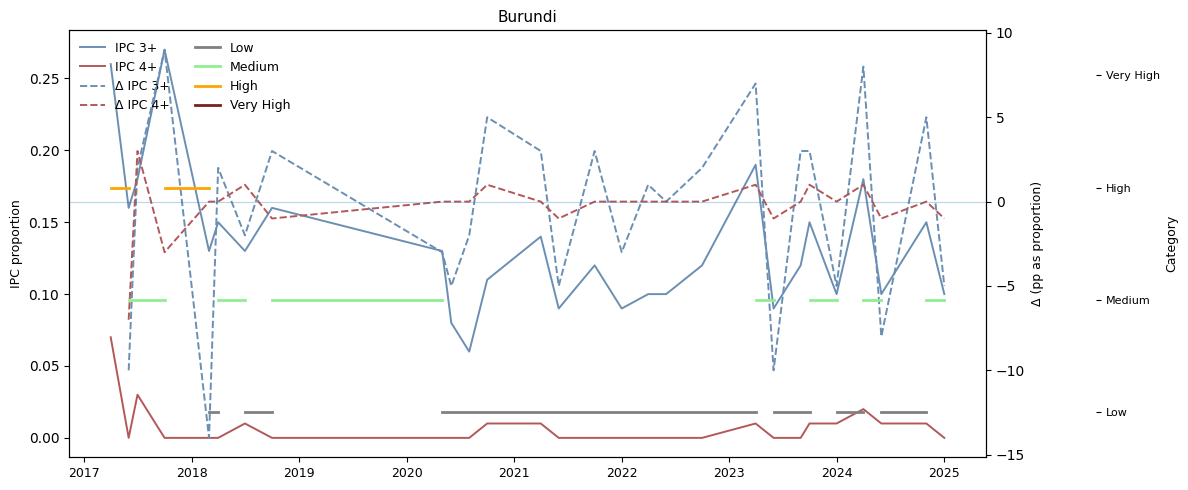

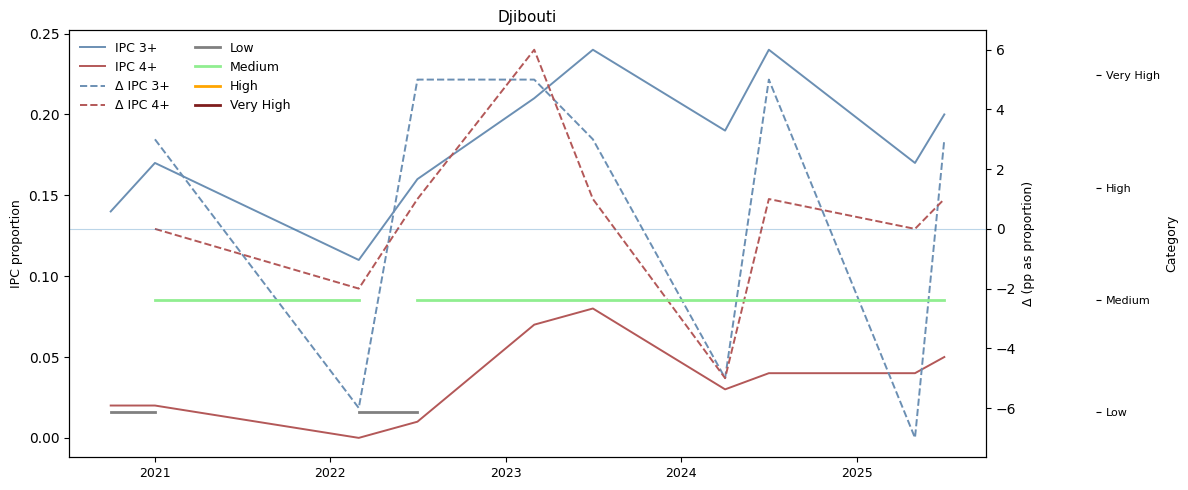

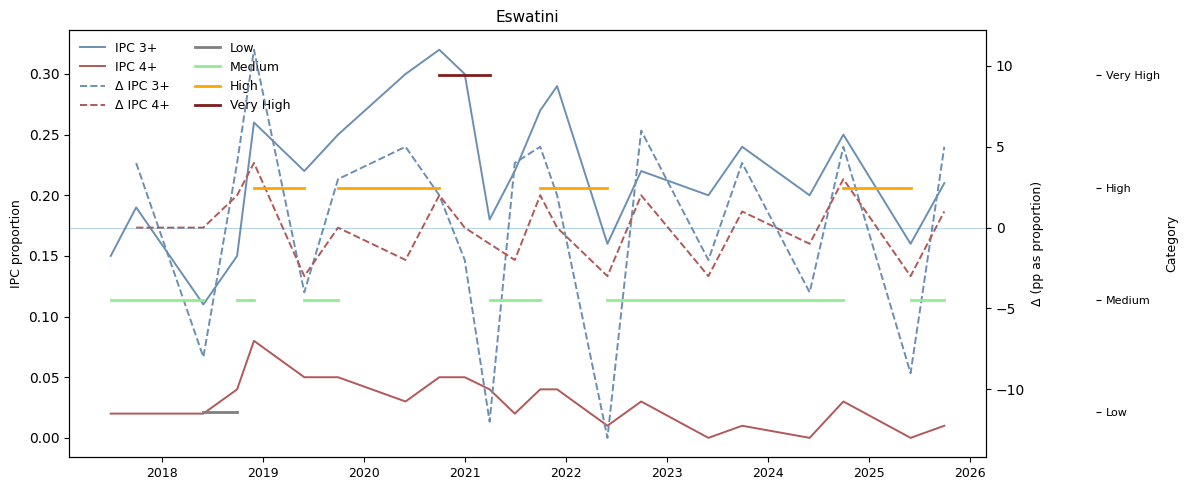

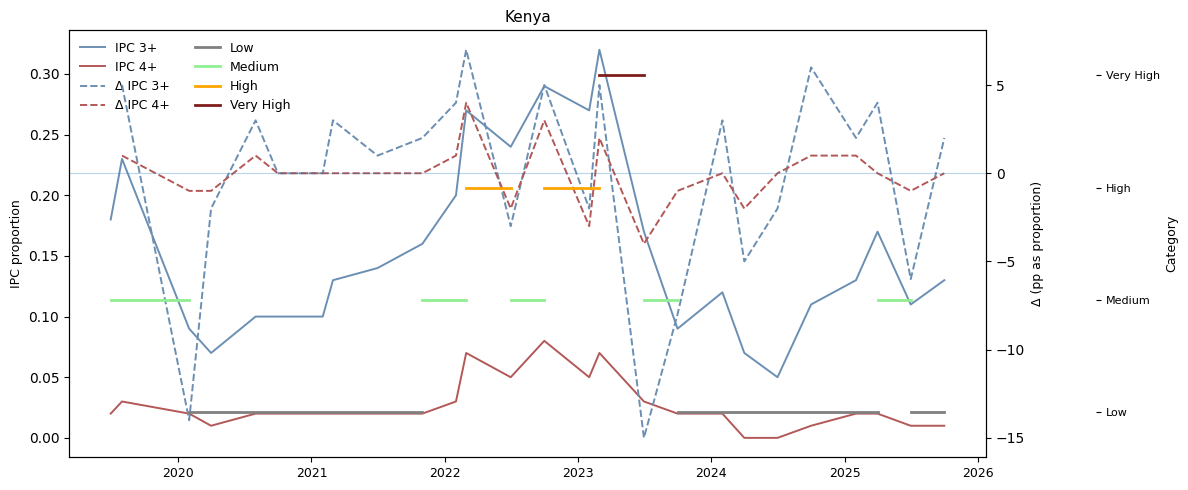

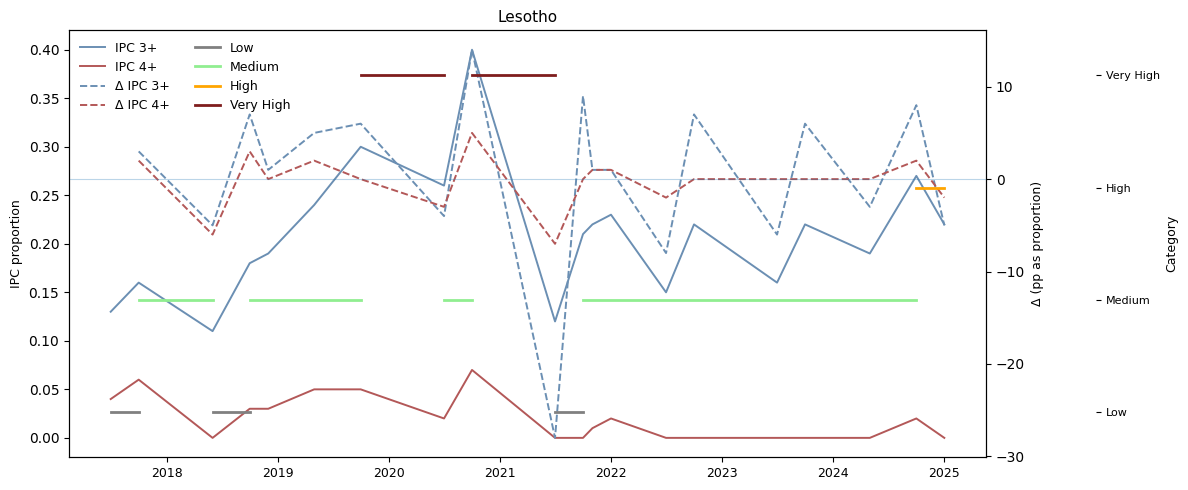

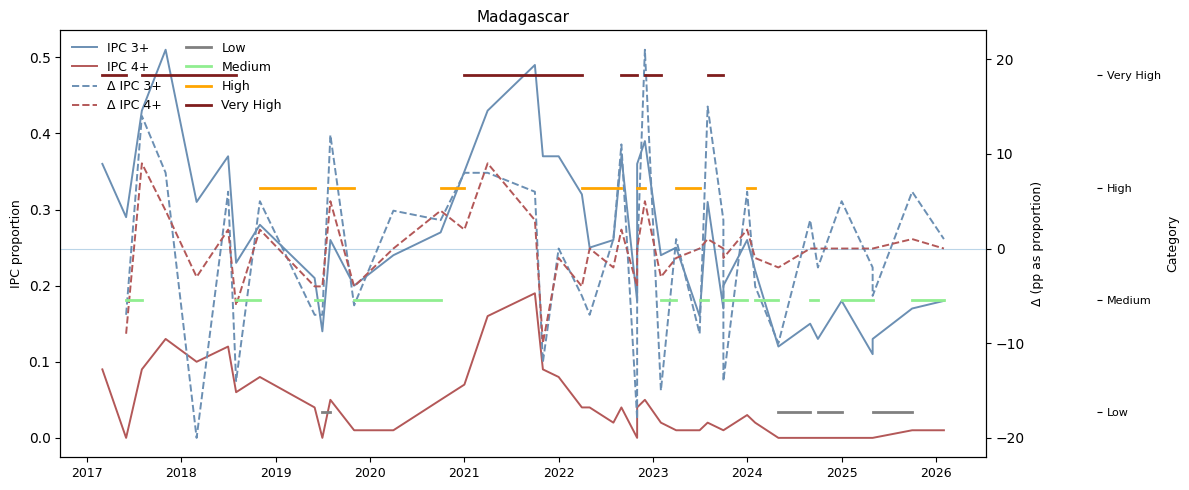

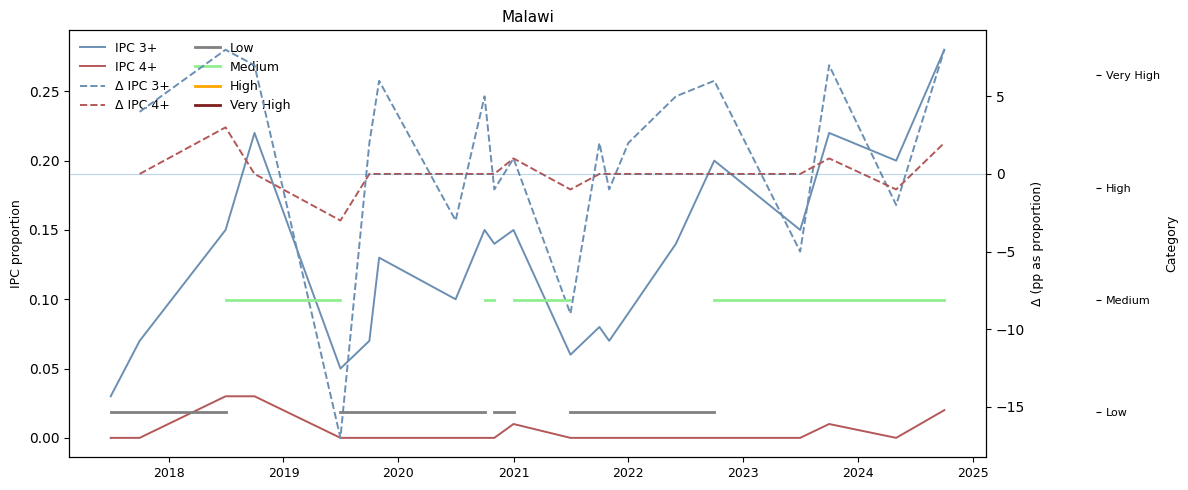

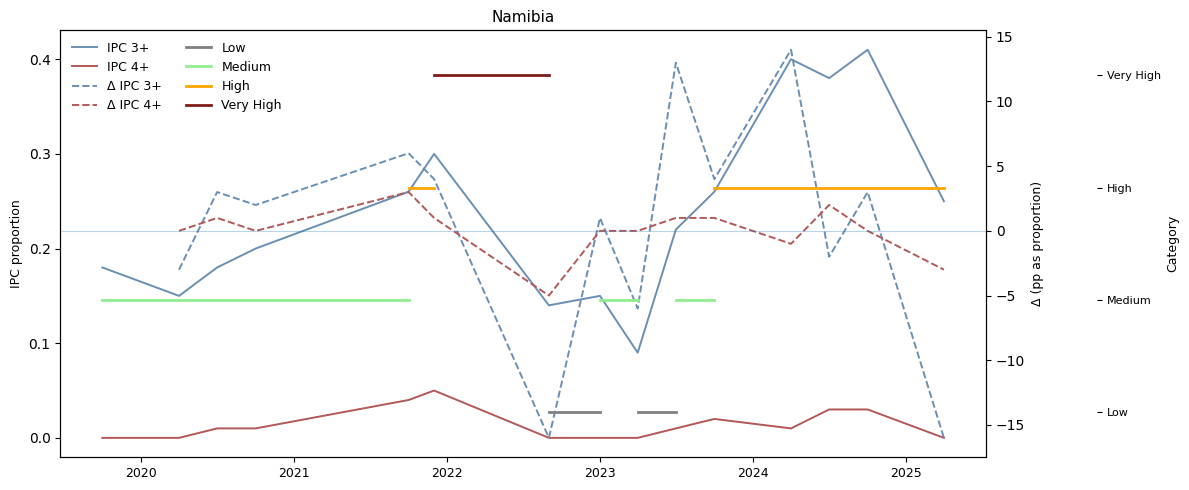

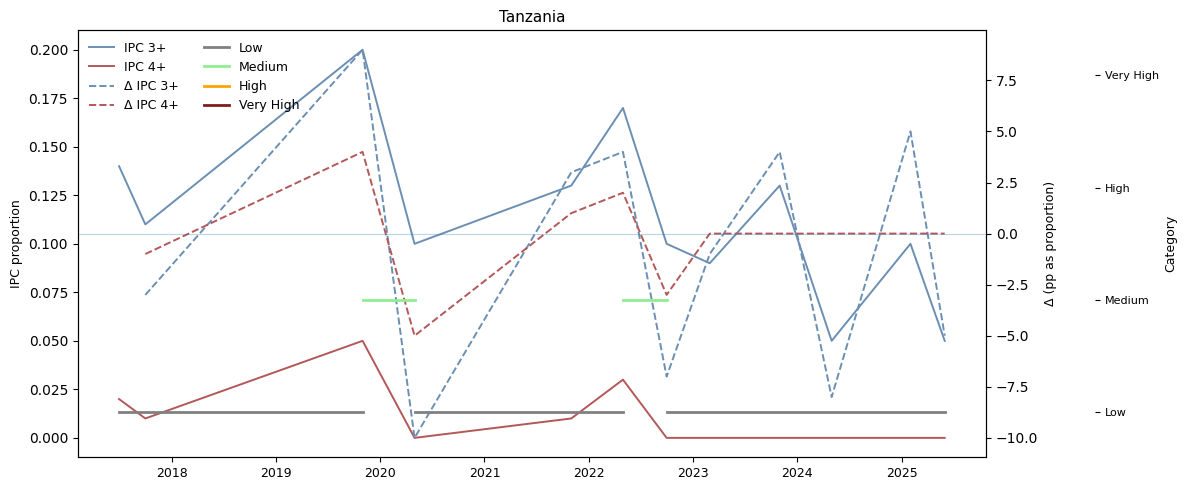

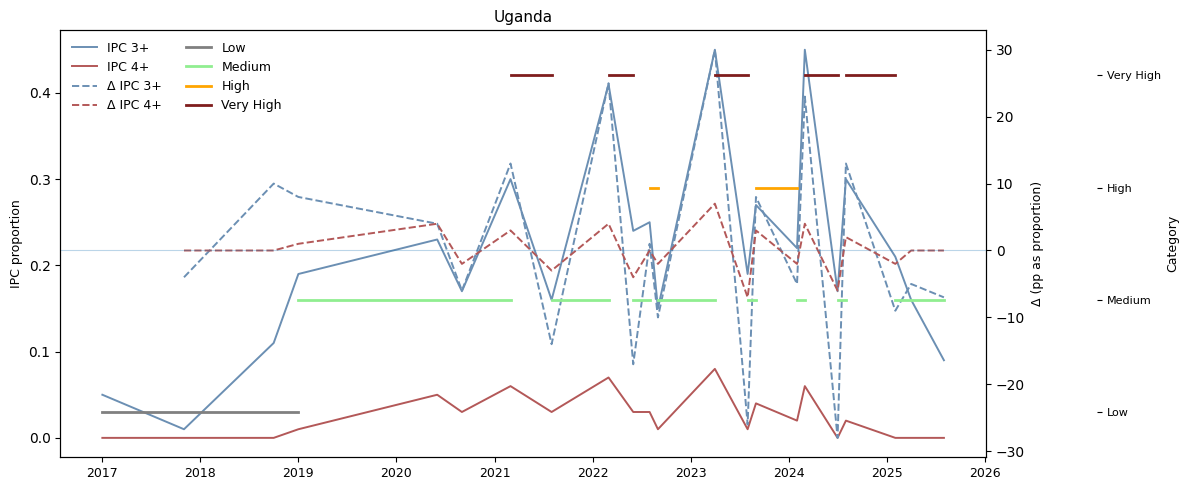

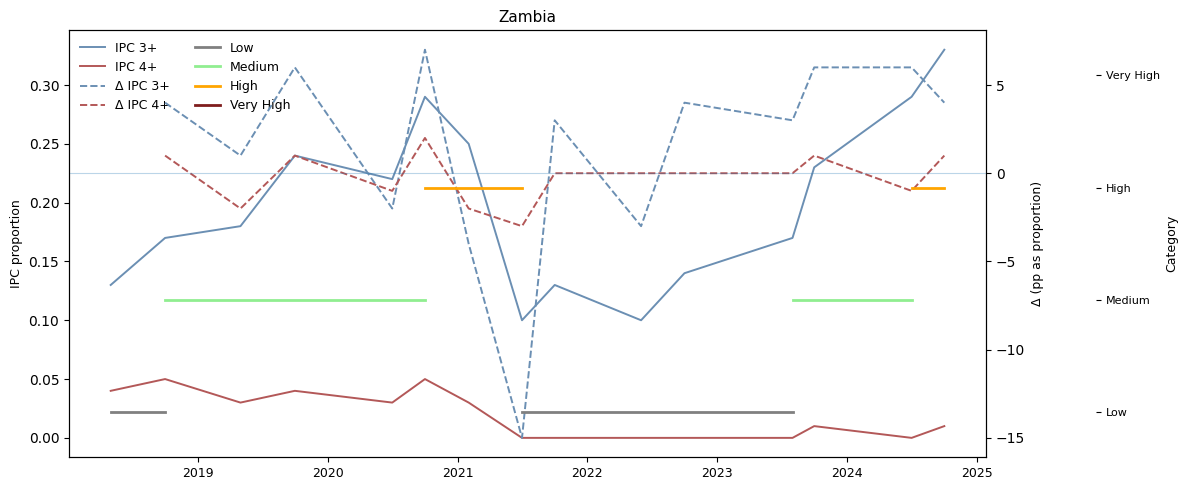

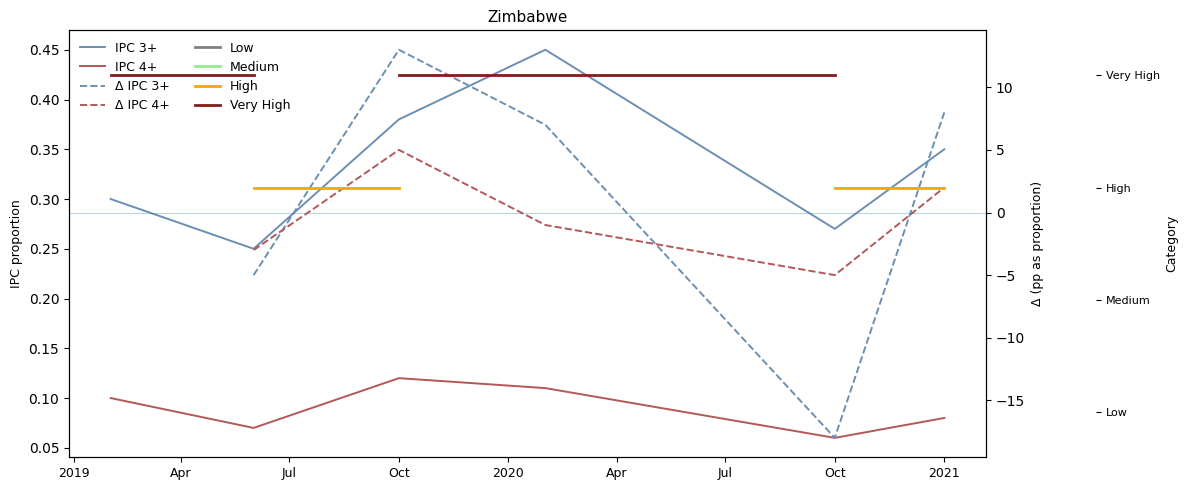

In [111]:
df = ipc_df.copy()
df["From_dt"] = pd.to_datetime(df["From"], errors="coerce")
df["To_dt"]   = pd.to_datetime(df["To"],   errors="coerce")
df = df.dropna(subset=["country", "From_dt"]).sort_values(["country", "From_dt", "To_dt"])

long_lvl = df.melt(
    id_vars=["country", "From_dt"],
    value_vars=["proportion_3+", "proportion_4+"],
    var_name="metric", value_name="value"
).dropna(subset=["value"]).sort_values(["country", "From_dt", "metric"])

long_chg = df.melt(
    id_vars=["country", "From_dt"],
    value_vars=["pt_change_3+", "pt_change_4+"],
    var_name="metric", value_name="value"
).dropna(subset=["value"]).sort_values(["country", "From_dt", "metric"])

countries = sorted(long_lvl["country"].dropna().unique())

# --- Colors ---
c3 = "#6b8fb3"  # IPC 3+
c4 = "#b35858"  # IPC 4+
cat_to_y = {"Low": 0, "Medium": 1, "High": 2, "Very High": 3}
cat_colors = {
    "Low": "#808080",        # grey
    "Medium": "#90ee90",     # light green
    "High": "#ffa500",       # orange
    "Very High": "#7f1d1d",  # wine red
}

# --- Category assignment ---
def assign_cat_row(row):
    P3 = row.get("proportion_3+", np.nan)
    P4 = row.get("proportion_4+", np.nan)
    D3 = row.get("pt_change_3+", np.nan)
    D4 = row.get("pt_change_4+", np.nan)

    if (P3 >= 0.50) or (P3 >= 0.30 and P4 >= 0.05) or (P3 >= 0.30 and D3 >= 0.05 and D4 >= 0.02):
        return "Very High"
    if (P3 >= 0.30) or (P3 >= 0.25 and D3 >= 0.03) or (P3 >= 0.25 and P4 >= 0.03) or (P3 >= 0.30 and D3 >= 0.03):
        return "High"
    if 0.15 <= P3 <= 0.30:
        return "Medium"
    return "Low"

df["category"] = df.apply(assign_cat_row, axis=1)

# --- Plot per country ---
for c in countries:
    subL = long_lvl[long_lvl["country"] == c].sort_values("From_dt")
    subC = long_chg[long_chg["country"] == c].sort_values("From_dt")
    base = df[df["country"] == c].sort_values("From_dt")

    cat_series = base[["From_dt", "category"]].dropna().copy()
    cat_series["y"] = cat_series["category"].map(cat_to_y)

    fig, ax = plt.subplots(figsize=(12, 5))
    ax2 = ax.twinx()
    ax3 = ax.twinx()
    ax3.spines["right"].set_position(("axes", 1.12))
    ax3.set_frame_on(False)
    ax3.patch.set_visible(False)

    # Levels
    s3L = subL[subL["metric"] == "proportion_3+"]
    s4L = subL[subL["metric"] == "proportion_4+"]
    if not s3L.empty:
        ax.plot(s3L["From_dt"], s3L["value"], lw=1.4, color=c3)
    if not s4L.empty:
        ax.plot(s4L["From_dt"], s4L["value"], lw=1.4, color=c4)
    ax.set_ylabel("IPC proportion", fontsize=9)

    # Changes
    s3C = subC[subC["metric"] == "pt_change_3+"]
    s4C = subC[subC["metric"] == "pt_change_4+"]
    if not s3C.empty:
        ax2.plot(s3C["From_dt"], s3C["value"], lw=1.4, ls="--", color=c3)
    if not s4C.empty:
        ax2.plot(s4C["From_dt"], s4C["value"], lw=1.4, ls="--", color=c4)
    ax2.axhline(0, lw=0.8, alpha=0.3)
    ax2.set_ylabel("Δ (pp as proportion)", fontsize=9)

    # Categories (colored steps)
    for cat, color in cat_colors.items():
        mask = cat_series["category"].eq(cat)
        if mask.any():
            y = np.where(mask, cat_series["y"], np.nan)
            ax3.plot(
                cat_series["From_dt"], y,
                lw=2.0, drawstyle="steps-post", color=color
            )
    ax3.set_ylim(-0.4, 3.4)
    ax3.set_yticks([0, 1, 2, 3])
    ax3.set_yticklabels(["Low", "Medium", "High", "Very High"], fontsize=8)
    ax3.set_ylabel("Category", fontsize=9)

    # X-axis formatting
    locator = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
    ax.tick_params(axis="x", labelsize=9)

    # Legend
    handles = [
        Line2D([0],[0], lw=1.4, color=c3, ls="-",  label="IPC 3+"),
        Line2D([0],[0], lw=1.4, color=c4, ls="-",  label="IPC 4+"),
        Line2D([0],[0], lw=1.4, color=c3, ls="--", label="Δ IPC 3+"),
        Line2D([0],[0], lw=1.4, color=c4, ls="--", label="Δ IPC 4+"),
        Line2D([0],[0], lw=2.0, color=cat_colors["Low"],       ls="-", label="Low"),
        Line2D([0],[0], lw=2.0, color=cat_colors["Medium"],    ls="-", label="Medium"),
        Line2D([0],[0], lw=2.0, color=cat_colors["High"],      ls="-", label="High"),
        Line2D([0],[0], lw=2.0, color=cat_colors["Very High"], ls="-", label="Very High"),
    ]
    ax.legend(handles=handles, loc="upper left", ncol=2, frameon=False, fontsize=9)

    ax.set_title(c, fontsize=11)
    plt.tight_layout()
    plt.show()

# --- Summary: how many times each category was reached per country ---
df = df.sort_values(["country", "From_dt"])
df["prev_category"] = df.groupby("country")["category"].shift()
df["is_entry"] = df["category"].ne(df["prev_category"])

summary = (
    df[df["is_entry"]]
      .groupby(["country", "category"])
      .size()
      .rename("n_times_reached")
      .reset_index()
      .pivot(index="country", columns="category", values="n_times_reached")
      .fillna(0)
      .astype(int)
)

In [112]:
summary

category,High,Low,Medium,Very High
country,,,,
Angola,0,0,0,1
Burundi,2,7,7,0
Djibouti,0,2,2,0
Eswatini,4,1,6,1
Kenya,2,3,5,1
Lesotho,1,3,5,2
Madagascar,7,4,12,6
Malawi,1,4,4,0
Namibia,2,2,4,1


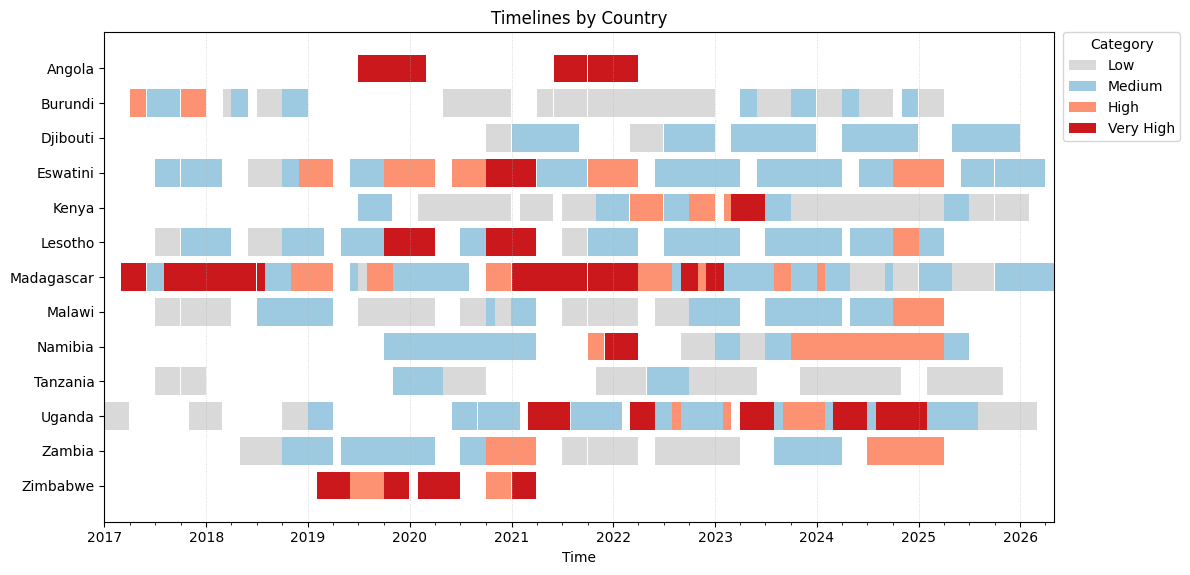

In [113]:
df = ipc_df.copy()
df['country'] = df['country'].astype(str).str.strip()
df['From_dt'] = pd.to_datetime(df['From'], format = "%b %d, %Y", errors='coerce')
df['To_dt']   = pd.to_datetime(df['To'], format = "%b %d, %Y", errors='coerce')

df['d3_prop'] = df['pt_change_3+'] / 100.0 
df['d4_prop'] = df['pt_change_4+'] / 100.0 

df = df.dropna(subset=['country']).sort_values(['country', 'From_dt', 'To_dt'])

df['prev_p3'] = df.groupby('country')['proportion_3+'].shift(1)
df['prev_p4'] = df.groupby('country')['proportion_4+'].shift(1)

p3 = df['proportion_3+']
p4 = df['proportion_4+']
d3 = df['d3_prop']     
d4 = df['d4_prop']  

#prev_high_ok  = (df['prev_p3'] >= 0.15)
#prev_vhigh_ok = (df['prev_p3'] >= 0.15) & (df['prev_p4'] >= 0.01)

#high_logic  = (p3 >= 0.2) & ( ((d3 >= 0.05) & (p4 >= 0.01)) | prev_high_ok )
#vhigh_logic = (p3 >= 0.25) & ( ((d3 >= 0.10) & (p4 >= 0.02)) | prev_vhigh_ok )

def assign_cat(i):
    P3 = p3.iloc[i]  # IPC 3+ proportion (0..1)
    P4 = p4.iloc[i]  # IPC 4+ proportion (0..1)
    D3 = d3.iloc[i]  # Δ IPC 3+ in pp as proportion (0.03 = +3pp)
    D4 = d4.iloc[i]  # Δ IPC 4+ in pp as proportion

    # Very High (inclusive)
    if (P3 >= 0.50) or (P3 >= 0.30 and P4 >= 0.05) or (P3 >= 0.30 and D3 >= 0.05 and D4 >= 0.02):
        return "Very High"

    # High (inclusive; deterioration paths require D3 ≥ 3pp)
    if (P3 >= 0.30) or (P3 >= 0.25 and D3 >= 0.03) or (P3 >= 0.25 and P4 >= 0.03) or (P3 >= 0.30 and D3 >= 0.03):
        return "High"

    # Medium band (inclusive of 0.15 and 0.30)
    if 0.15 <= P3 <= 0.30:
        return "Medium"

    # Low
    return "Low"


df['category'] = [assign_cat(i) for i in range(len(df))]

countries = sorted(ipc_df['country'].dropna().astype(str).str.strip().unique())

dfv = df.dropna(subset=['From_dt','To_dt'])
dfv = dfv[dfv['To_dt'] >= dfv['From_dt']].copy()

cat_order = ["Low", "Medium", "High", "Very High"]
cmap = ListedColormap(["#d9d9d9", "#9ecae1", "#fc9272", "#cb181d"])
cat_to_color = dict(zip(cat_order, cmap.colors))

if not dfv.empty:
    xmin = dfv['From_dt'].min()
    xmax = dfv['To_dt'].max()
else:
    xmin = pd.Timestamp("2000-01-01")
    xmax = pd.Timestamp("2001-01-01")

y_gap = 0.8
fig_h = max(4.5, 0.45*len(countries))
fig, ax = plt.subplots(figsize=(12, fig_h))

for i, country in enumerate(countries):
    sub = dfv[dfv['country'] == country].sort_values('From_dt')
    y = i
    if sub.empty:
        ax.broken_barh([(mdates.date2num(xmin), mdates.date2num(xmax)-mdates.date2num(xmin))],
                       (y - y_gap/2, y_gap),
                       facecolors='none', edgecolors='#eeeeee', linewidth=0.8, linestyles='dashed')
    else:
        for _, r in sub.iterrows():
            left  = mdates.date2num(r['From_dt'])
            right = mdates.date2num(r['To_dt'])
            width = max(right - left, 1/24)  # min width for visibility
            color = cat_to_color.get(r['category'], "#d9d9d9")
            ax.broken_barh([(left, width)], (y - y_gap/2, y_gap),
                           facecolors=color, edgecolors='none')

ax.set_yticks(range(len(countries)))
ax.set_yticklabels(countries)
ax.invert_yaxis()

ax.set_xlim(mdates.date2num(xmin), mdates.date2num(xmax))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1,4,7,10)))
ax.grid(True, axis='x', which='major', linestyle=':', linewidth=0.6, alpha=0.6)

ax.set_xlabel("Time")
ax.set_title("Timelines by Country")

legend_handles = [Patch(facecolor=cat_to_color[c], edgecolor='none', label=c) for c in cat_order]
ax.legend(handles=legend_handles, title="Category",
          bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

In [114]:
fa = fa_df.copy()
fa.columns = [c.strip() for c in fa.columns]
fa["fa_date"] = pd.to_datetime(fa["Original PDF Publication Date"], dayfirst=True, errors="coerce")
fa["country_key"] = fa["Country Name"].astype(str).str.strip().str.casefold()
fa = fa.dropna(subset=["country_key", "fa_date"])

surge = surge_df.copy()
surge["dep_date"]      = pd.to_datetime(surge["Date of departure"], dayfirst=True, errors="coerce")
surge["country_key"]   = surge["Destination Country"].astype(str).str.strip().str.casefold()
surge["surge_type_l"]  = surge["Surge"].astype(str).str.strip().str.casefold()  # 'remote' / 'physical'
surge["days"]          = pd.to_numeric(surge["Days"], errors="coerce").fillna(0)
surge = surge.dropna(subset=["country_key","dep_date"])

surge["year"]     = surge["dep_date"].dt.year
surge["quarter"]  = surge["dep_date"].dt.quarter
surge["q_mid_dt"] = pd.to_datetime({
    "year": surge["year"],
    "month": (surge["quarter"] - 1) * 3 + 2,  # mid-quarter
    "day": 15
})

# sum DAYS per country × year × quarter × surge type
surge_q = (
    surge.groupby(["country_key","year","quarter","surge_type_l"], as_index=False)
         .agg(total_days=("days","sum"),
              q_mid_dt=("q_mid_dt","first"))
)

# size scale by total_days (adjust constants to taste)
if not surge_q.empty:
    dmax = surge_q["total_days"].max()
    surge_q["size"] = 36 + 100 * np.sqrt(surge_q["total_days"] / dmax)
else:
    surge_q["size"] = 0

cerf = cerf_df.copy()

# Clean & types
cerf["regionName_l"] = cerf["regionName"].astype(str).str.strip().str.casefold()
cerf["emergencyTypeName_l"] = cerf["emergencyTypeName"].astype(str).str.strip().str.casefold()
cerf["window_l"] = cerf["windowFullName"].astype(str).str.strip().str.casefold()
cerf["dateUSGSignature"] = pd.to_datetime(cerf["dateUSGSignature"], errors="coerce")
cerf["totalAmountApproved"] = pd.to_numeric(cerf["totalAmountApproved"], errors="coerce").fillna(0)

# Filter (Drought in Eastern/Southern Africa) — adjust if needed
region_keep = {"eastern africa", "southern africa"}
mask = cerf["emergencyTypeName_l"].eq("drought") & cerf["regionName_l"].isin(region_keep)
cerf_sub = cerf.loc[mask].dropna(subset=["dateUSGSignature"]).copy()

# Quarter + mid-quarter date
cerf_sub["year"] = cerf_sub["dateUSGSignature"].dt.year
cerf_sub["quarter"] = cerf_sub["dateUSGSignature"].dt.quarter
cerf_sub["q_mid_dt"] = pd.to_datetime({
    "year": cerf_sub["year"],
    "month": (cerf_sub["quarter"] - 1) * 3 + 2,  # Feb, May, Aug, Nov
    "day": 15
})

# Window type
cerf_sub["window_type"] = np.where(
    cerf_sub["window_l"].str.contains("rapid", na=False), "RR",
    np.where(cerf_sub["window_l"].str.contains("underfund", na=False), "UFE", "OTHER")
)

# Group to quarterly bubbles
by_qtr_win = (
    cerf_sub.groupby(["countryName", "year", "quarter", "window_type"], as_index=False)
            .agg(total_approved=("totalAmountApproved", "sum"),
                 q_mid_dt=("q_mid_dt", "first"))
            .rename(columns={"countryName": "country"})
)

# Optional: clip to your timeline if xmin/xmax exist
if "xmin" in globals() and "xmax" in globals():
    by_qtr_win = by_qtr_win[(by_qtr_win["q_mid_dt"] >= xmin) & (by_qtr_win["q_mid_dt"] <= xmax)].copy()

# Bubble size for plotting
if not by_qtr_win.empty:
    amax = by_qtr_win["total_approved"].max()
    by_qtr_win["size"] = 28 + 100 * np.sqrt(by_qtr_win["total_approved"] / amax)
else:
    by_qtr_win["size"] = 0

# Join key for matching to country lanes
by_qtr_win["country_key"] = by_qtr_win["country"].astype(str).str.strip().str.casefold()


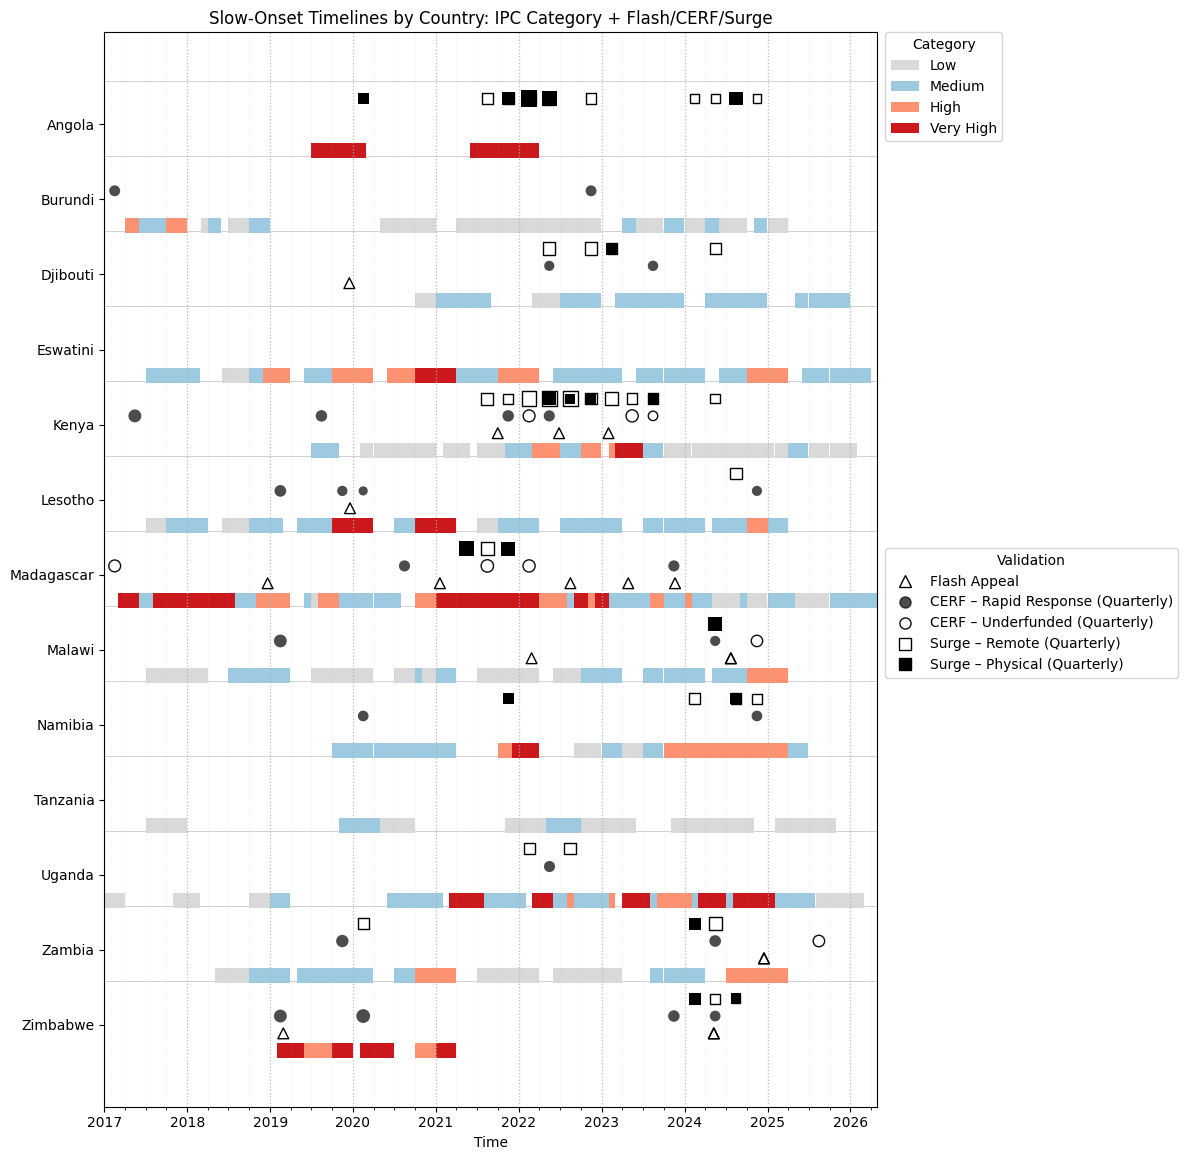

In [115]:
cat_order = ["Low","Medium","High","Very High"]

# Sequential (light→dark) severity palette
cmap = ListedColormap(["#d9d9d9", "#9ecae1", "#fc9272", "#cb181d"])
cat_to_color = dict(zip(cat_order, cmap.colors))

# --- lane layout per country (stacked mini-rows) ---
# For each country, use a block height H with four lanes:
#   0: Surge, 1: CERF, 2: Flash, 3: Category (thin ribbon)
countries = sorted(dfv['country'].dropna().unique())
#fig_h = max(6, 0.55 * len(countries) * (H / 1.2))  # scale height with lanes
#fig, ax = plt.subplots(figsize=(12, fig_h))
H = 2.6
lane_y = {"cat": 2.2, "flash": 1.6, "cerf": 1.0, "surge": 0.4}
cat_height = 0.5
fig, ax = plt.subplots(figsize=(12, max(6, 0.90 * len(countries))))

for i, country in enumerate(countries):
    key = str(country).strip().casefold()
    base = i * H

    # --- Category ribbon (top lane) ---
    sub = dfv[dfv['country'] == country].sort_values('From_dt')
    if not sub.empty:
        for _, r in sub.iterrows():
            left  = mdates.date2num(r['From_dt'])
            right = mdates.date2num(r['To_dt'])
            width = max(right - left, 1/24)
            ax.broken_barh(
                [(left, width)],
                (base + lane_y["cat"] - cat_height/2, cat_height),
                facecolors=cat_to_color.get(r['category'], cmap.colors[0]),
                edgecolors='none',
                zorder=1
            )
    else:
        ax.broken_barh(
            [(mdates.date2num(xmin), mdates.date2num(xmax) - mdates.date2num(xmin))],
            (base + lane_y["cat"] - cat_height/2, cat_height),
            facecolors='none', edgecolors='#e0e0e0', linewidth=0.8, linestyles='dashed', zorder=1
        )

    # --- Flash Appeals (second lane) ---
    fsub = fa[fa["country_key"] == key]
    if not fsub.empty:
        ax.scatter(fsub["fa_date"], np.full(len(fsub), base + lane_y["flash"]),
                   marker="^", s=60, facecolors="none", edgecolors="black",
                   linewidths=1.0, zorder=3)

    # --- CERF bubbles (third lane: RR filled, UFE hollow) ---
    b = by_qtr_win[by_qtr_win["country_key"] == key]
    if not b.empty:
        rr  = b[b["window_type"] == "RR"]
        ufe = b[b["window_type"] == "UFE"]
        if not rr.empty:
            ax.scatter(rr["q_mid_dt"], np.full(len(rr), base + lane_y["cerf"]),
                       s=rr["size"], marker="o", facecolors="black", edgecolors="black",
                       alpha=0.70, linewidths=0, zorder=3)
        if not ufe.empty:
            ax.scatter(ufe["q_mid_dt"], np.full(len(ufe), base + lane_y["cerf"]),
                       s=ufe["size"], marker="o", facecolors="none", edgecolors="black",
                       alpha=0.95, linewidths=1.0, zorder=3)

    # --- Surge (bottom lane): Remote = hollow; Physical = filled ---
    s = surge_q[surge_q["country_key"] == key]
    if not s.empty:
        s_remote   = s[s["surge_type_l"].str.contains("remote",   na=False)]
        s_physical = s[s["surge_type_l"].str.contains("physical", na=False)]
        if not s_remote.empty:
            ax.scatter(s_remote["q_mid_dt"], np.full(len(s_remote), base + lane_y["surge"]),
                       marker="s", s=s_remote["size"], facecolors="none", edgecolors="black",
                       linewidths=1.0, zorder=3)
        if not s_physical.empty:
            ax.scatter(s_physical["q_mid_dt"], np.full(len(s_physical), base + lane_y["surge"]),
                       marker="s", s=s_physical["size"], facecolors="black", edgecolors="black",
                       linewidths=0.0, zorder=3)

    # --- block separator (adjusted for slimmer lanes) ---
    ax.hlines(base - 0.2, mdates.date2num(xmin), mdates.date2num(xmax),
              colors="#bdbdbd", linestyles="-", linewidth=0.6, alpha=0.8, zorder=0)

# --- y-axis: label each country at block center ---
ax.set_yticks([i*H + H/2 for i in range(len(countries))])
ax.set_yticklabels(countries)
ax.invert_yaxis()

# --- x-axis limits & stronger year grid ---
ax.set_xlim(mdates.date2num(xmin), mdates.date2num(xmax))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1,4,7,10)))

# Major year grid: a bit bolder; minor quarter grid: light dotted
ax.grid(True, axis='x', which='major', linestyle=':', linewidth=0.9, alpha=0.85)
ax.grid(True, axis='x', which='minor', linestyle=':', linewidth=0.4, alpha=0.35)

ax.set_xlabel("Time")
ax.set_title("Slow-Onset Timelines by Country: IPC Category + Flash/CERF/Surge")

# --- Legends ---
legend_handles = [Patch(facecolor=cat_to_color[c], edgecolor='none', label=c) for c in cat_order]
leg1 = ax.legend(handles=legend_handles, title="Category",
                 bbox_to_anchor=(1.01, 1.00), loc='upper left', borderaxespad=0.)
ax.add_artist(leg1)

rr_key   = Line2D([0],[0], marker='o', linestyle='None',
                  markerfacecolor='black', markeredgecolor='black',
                  alpha=0.70, markersize=8, label='CERF – Rapid Response (Quarterly)')
ufe_key  = Line2D([0],[0], marker='o', linestyle='None',
                  markerfacecolor='none', markeredgecolor='black',
                  alpha=0.95, markersize=8, label='CERF – Underfunded (Quarterly)')
flash_key = Line2D([0],[0], marker="^", linestyle="None",
                   markerfacecolor="none", markeredgecolor="black",
                   markersize=8, label="Flash Appeal")
surge_remote_key  = Line2D([0],[0], marker="s", linestyle="None",
                           markerfacecolor="none", markeredgecolor="black",
                           markersize=8, label="Surge – Remote (Quarterly)")
surge_phys_key    = Line2D([0],[0], marker="s", linestyle="None",
                           markerfacecolor="black", markeredgecolor="black",
                           markersize=8, label="Surge – Physical (Quarterly)")

ax.legend(handles=[flash_key, rr_key, ufe_key, surge_remote_key, surge_phys_key],
          title="Validation",
          bbox_to_anchor=(1.01, 0.52), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()
